# Домашнее задание № 4

## по дисциплине: Машинное обучение в бизнесе

### выполнил: Евгений Кириллов

## Задача 1, 2, 3, 4

скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

сделать разбиение набора данных не тренировочную и тестовую выборки

сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler

import itertools
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("lesson_4_uplift/data_HW4/data.csv")
df.head(1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0


In [3]:
df.columns = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 
              'is_referral', 'channel', 'treatment', 'target']
df.head(1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0


In [4]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), 
                                                    df['target'], random_state=0)

In [6]:
class DataPreprocessingAndFeatureGenerating:
    def __init__(self):
        self.scaler = StandardScaler()
        self.list_of_features_to_scale = ['recency', 'history']
    
    def fit(self, X):
        self.scaler.fit(X[self.list_of_features_to_scale])
        
    def transform(self, X):
        X[self.list_of_features_to_scale] = self.scaler.transform(X[self.list_of_features_to_scale])
        X = pd.get_dummies(X)
        return X

In [7]:
data_preprocessor_and_feature_generator = DataPreprocessingAndFeatureGenerating()

In [8]:
data_preprocessor_and_feature_generator.fit(X_train)

In [9]:
X_train = data_preprocessor_and_feature_generator.transform(X_train)
X_test = data_preprocessor_and_feature_generator.transform(X_test) 

In [10]:
X_train.shape

(48000, 12)

In [11]:
X_test.shape

(16000, 12)

## Задача 5

Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

### модель с признаком коммуникации (S learner) (without sklift package)

In [12]:
lr = LogisticRegression()

In [13]:
lr.fit(X_train, y_train)

LogisticRegression()

In [14]:
X_train_treatment_0 = X_train.copy()
X_train_treatment_0['treatment'] = 0
X_train_treatment_1 = X_train.copy()
X_train_treatment_1['treatment'] = 1

In [15]:
uplift_train = lr.predict_proba(X_train_treatment_1)[:, 1] - lr.predict_proba(X_train_treatment_0)[:, 1]
uplift_train = pd.Series(uplift_train, index=y_train.index)

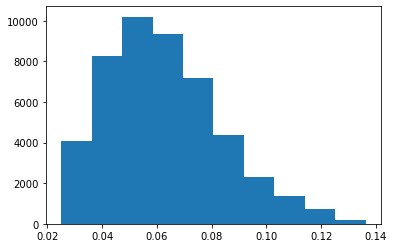

In [16]:
plt.hist(uplift_train)
plt.show()

In [17]:
X_test_treatment_0 = X_test.copy()
X_test_treatment_0['treatment'] = 0
X_test_treatment_1 = X_test.copy()
X_test_treatment_1['treatment'] = 1

In [18]:
uplift_test = lr.predict_proba(X_test_treatment_1)[:, 1] - lr.predict_proba(X_test_treatment_0)[:, 1]
uplift_test = pd.Series(uplift_test, index=y_test.index)

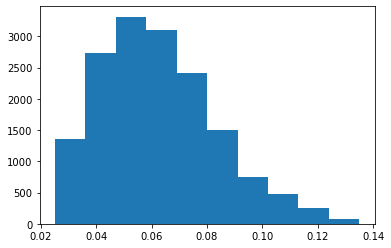

In [19]:
plt.hist(uplift_test)
plt.show()

## doing the same, but with sklift package

In [20]:
# !pip install scikit-uplift

In [21]:
from sklift.models import SoloModel
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds

In [22]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

#### separation 'treatment' from X_train and X_test

In [23]:
treat_train = X_train['treatment']
X_train = X_train.drop('treatment', axis=1)

treat_test = X_test['treatment']
X_test = X_test.drop('treatment', axis=1)

## SoloModel

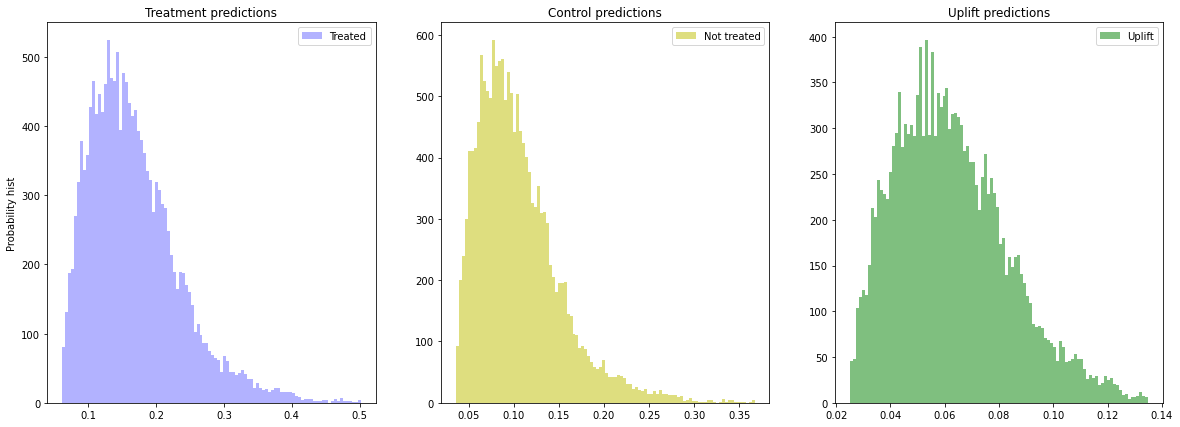

In [24]:
sm = SoloModel(LogisticRegression())
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params=None)

uplift_sm = sm.predict(X_test)

# размер uplift на топ k процентах выборки
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)  # 10%
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)  # 20%

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds, bins=100);#ctrl_preds=

In [25]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.06449473728885496],
 'uplift@20%': [0.06372801156690563]}

## ClassTransformation

In [26]:
from sklift.models import ClassTransformation

In [27]:
ct = ClassTransformation(LogisticRegression())
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params=None)

uplift_ct = ct.predict(X_test)

# размер uplift на топ k процентах выборки
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)  # 10%
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)  # 20%

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

In [28]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.06449473728885496, 0.06729585773703423],
 'uplift@20%': [0.06372801156690563, 0.07369174125765354]}

## TwoModels

In [29]:
from sklift.models import TwoModels

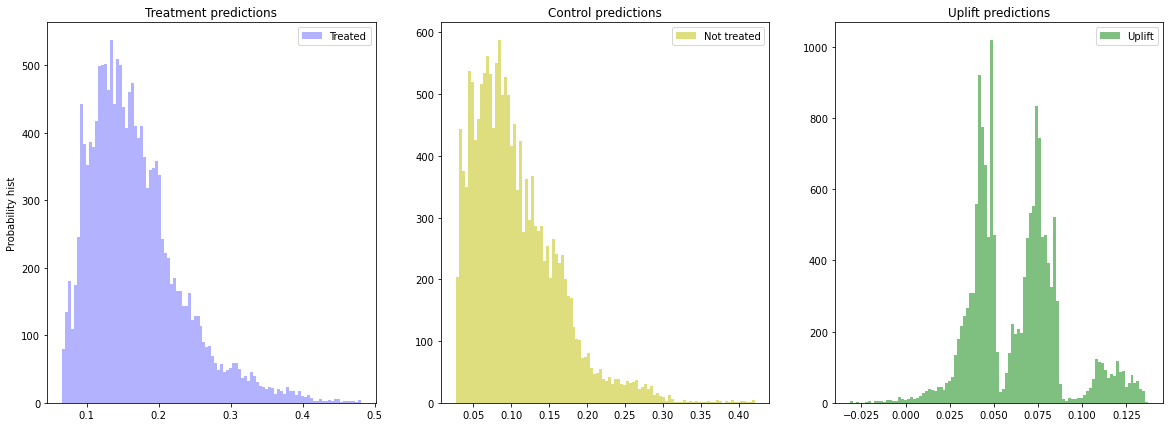

In [30]:
tm = TwoModels(     
    estimator_trmnt=LogisticRegression(), 
    estimator_ctrl=LogisticRegression(), 
    method='vanilla'
)   

# method ='ddr_control' ('ddr_treatment') - зависимые модели
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params=None, 
    estimator_ctrl_fit_params=None
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [31]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.06449473728885496, 0.06729585773703423, 0.0834871827518886],
 'uplift@20%': [0.06372801156690563, 0.07369174125765354, 0.0608588215331099]}

## Задача 6

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [32]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.064495,0.063728
1,ClassTransformation,0.067296,0.073692
2,TwoModels,0.083487,0.060859


## Задача 7

построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

## Задача 8

(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

In [38]:
from sklift.metrics import uplift_by_percentile

# uplift by decile, или  uplift by percentile, или uplift by bin.
uplift_by_percentile(y_test, uplift_sm,  treat_test, 
                     strategy='overall', 
                     total=True, std=True, bins=10)

C:\Users\fross\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1065,535,0.259155,0.196262,0.062893,0.013427,0.017171,0.021797
10-20,1079,521,0.218721,0.153551,0.065170,0.012585,0.015795,0.020195
20-30,1087,513,0.210672,0.148148,0.062523,0.012369,0.015685,0.019975
30-40,1040,560,0.175962,0.114286,0.061676,0.011808,0.013445,0.017894
40-50,1094,506,0.168190,0.112648,0.055542,0.011308,0.014055,0.018040
50-60,1061,539,0.176249,0.094620,0.081629,0.011698,0.012607,0.017198
60-70,1081,519,0.142461,0.123314,0.019147,0.010631,0.014433,0.017925
70-80,1063,537,0.113829,0.065177,0.048652,0.009741,0.010652,0.014435
80-90,1065,535,0.092019,0.054206,0.037813,0.008857,0.009789,0.013201
